## Fraud detection 

### Main challenges involved in credit card fraud detection are:

Enormous Data is processed every day and the model build must be fast enough to respond to the scam in time.

Imbalanced Data i.e most of the transactions (99.8%) are not fraudulent which makes it really hard for detecting the fraudulent ones

Data availability as the data is mostly private.

Misclassified Data can be another major issue, as not every fraudulent transaction is caught and reported.

Adaptive techniques used against the model by the scammers.

### Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow 

## Load Data

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Splitting features and labels

In [13]:
# Splitting features and labels
X = df.drop(columns=['Class'])
y = df['Class']
print(X.columns)



Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


### Splitting into training and testing sets

In [14]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalizing the data

In [23]:
# Normalizing the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [16]:
# # Combining the normalized features and labels back into a DataFrame
# scaled_df_train = pd.DataFrame(X_train, columns=X.columns)
# scaled_df_train['Class'] = y_train.values

# scaled_df_test = pd.DataFrame(X_test, columns=X.columns)
# scaled_df_test['Class'] = y_test.values

# scaled_df = pd.concat([scaled_df_train, scaled_df_test])

### Calculating the outlier fraction

In [49]:
# Calculating the outlier fraction
fraud = df[df['Class'] == 1] 
valid = df[df['Class'] == 0] 

if len(valid) > 0:
    outlierFraction = len(fraud) / float(len(valid))
    print(outlierFraction)
    print('Fraud Cases: {}'.format(len(scaled_df[scaled_df['Class'] == 1])))
else:
    print("No valid transactions in the dataset.")

0.0017304750013189597
Fraud Cases: 492


### Choose a Model

In [50]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler


# Autoencoder architecture
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(64, activation=LeakyReLU(negative_slope=0.1))(input_layer)
decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the autoencoder using only normal transactions
autoencoder.fit(normal_transactions, normal_transactions, epochs=20, batch_size=256, shuffle=True,
                validation_data=(X_test, X_test), callbacks=[early_stopping])

# Using the trained autoencoder to reconstruct both normal and fraud transactions
reconstructions = autoencoder.predict(X)

# Calculating the reconstruction error
mse = np.mean(np.power(X - reconstructions, 2), axis=1)

# Set a threshold for the reconstruction error
threshold = np.percentile(mse, 95)  # For example, using the 80th percentile as the threshold

# Label instances as fraud or not based on the threshold
labels = np.where(mse > threshold, 1, 0)

# Printing the outlier fraction and number of fraud cases
outlierFraction = len(labels[labels==1]) / float(len(labels))
print(outlierFraction)
print('Fraud Cases: {}'.format(len(labels[labels==1])))

# # Using RandomOverSampler to oversample the minority class
# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# # Autoencoder model training with oversampled data
# autoencoder.fit(X_resampled, X_resampled, epochs=20, batch_size=100, shuffle=True,
#                 validation_data=(X_test, X_test), callbacks=[early_stopping])

# # Using the trained autoencoder to reconstruct both normal and fraud transactions
# reconstructions = autoencoder.predict(X)

# # Calculating the reconstruction error
# mse = np.mean(np.power(X - reconstructions, 2), axis=1)

# # Set a threshold for the reconstruction error
# threshold = np.percentile(mse, 90)  # For example, using the 80th percentile as the threshold

# # Label instances as fraud or not based on the threshold
# labels = np.where(mse > threshold, 1, 0)

# # Printing the outlier fraction and number of fraud cases
# outlierFraction = len(labels[labels==1]) / float(len(labels))
# print(outlierFraction)
# print('Fraud Cases: {}'.format(len(labels[labels==1])))


Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 0.8399 - val_loss: 0.6773
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.6459 - val_loss: 0.6665
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.6335 - val_loss: 0.6627
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.6316 - val_loss: 0.6598
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.6283 - val_loss: 0.6584
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.6243 - val_loss: 0.6573
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.6232 - val_loss: 0.6567
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.6311 - val_loss: 0.6564
Epoch 9/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.6321 - val_loss: 0.6561
Epoch 10/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.6232 - val_loss: 0.6558
Epoch 11/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.6274 - val_loss: 0.6557
Epoch 12/20
889/889 ━━━━━━━━━━

### Evaluating parameters

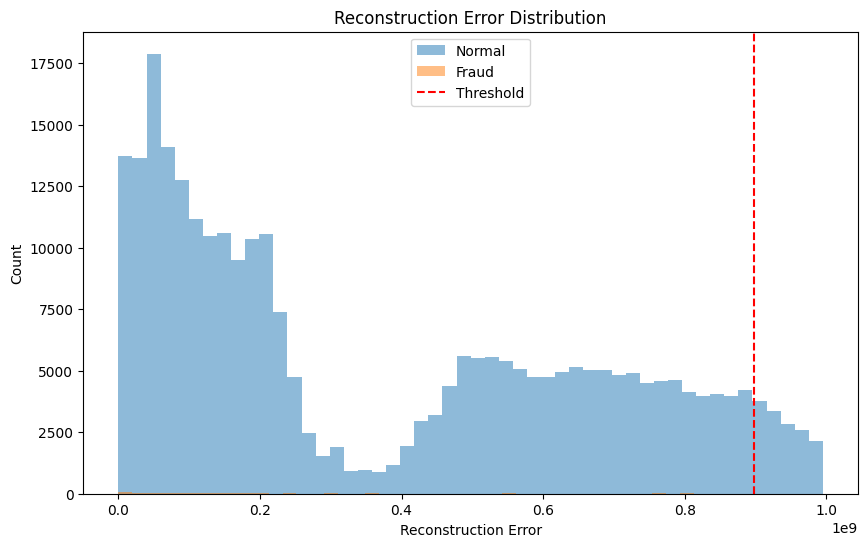

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.02      0.00       492

    accuracy                           0.95    284807
   macro avg       0.50      0.49      0.49    284807
weighted avg       1.00      0.95      0.97    284807

Confusion Matrix:
[[270085  14230]
 [   481     11]]


In [51]:
import matplotlib.pyplot as plt

# Plotting the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(mse[y == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(mse[y == 1], bins=50, alpha=0.5, label='Fraud')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Evaluating the performance of the autoencoder
from sklearn.metrics import classification_report, confusion_matrix

# Thresholding the reconstruction errors to get the predicted labels
predicted_labels = (mse > threshold).astype(int)

# Creating a confusion matrix
conf_matrix = confusion_matrix(y, predicted_labels)

# Printing the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y, predicted_labels))
print("Confusion Matrix:")
print(conf_matrix)

### Visualizing the Confusion Matrix